# Tutorial for infer_structcol package

In [4]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import seaborn as sns

# import package
import infer_structcol as ifs

## Set parameters

In [5]:
nwalkers = 6                                    # number of walkers to step through different parameters
nsteps = 100                                    # number of steps for each walker to take
particle_radius = 119                           # radius of colloidal particles in the colloidal glass
thickness = 120                                 # thickness of colloidal glass film
particle_index = 1.59                           # refractive index of colloidal particles
matrix_index = 1                                # refractive index of matrix material surrounding particles
wavelengths = [450,500,550,600,650,700,750,800] # wavelengths of interest where spectrum should be calculated
theta_guess = (0.59, 0.5, 0)                    # initial guess for the parameters to be inferred
directory = 'data_directory'                    # path where the data is found
reference_file = 'ref.txt'                      # name of reference file
dark_file = 'dark.txt'                          # name of dark file

## Infer parameters
##### Convert data into a spectrum file and load it
All data files for transmission (including reference and dark measurements) should be located in a directory called 'transmission', and all data files for reflection should be located in a directory called 'reflection'. They should be .txt files with two tab-separated columns, where the first is the wavelength and the second is the intensity. Any header information at the top or bottom of the file will be ignored. The reference and dark spectra should have unique names as specified by the user, and the transmission or reflection spectra can have any unspecified name. The code will assume that any file in the data directory other than the reference or dark files is a transmission or reflection spectrum. 

In [ ]:
# Normalize data using the reference and dark measurements, 
# and write to files with 3 columns: wavlength, normalized intensity, and standard deviation.
# There will be a converted data file for each transmission or reflection spectrum in the directory
ifs.convert_data(wavelengths, reference_file, dark_file, os.path.join(directory, 'reflection'))

# load the first converted data file as a spectrum object, 
# which contains the data relevant to the spectrum
spect = ifs.load_spectrum(refl_filepath = os.path.join(directory, 'reflection', 'converted', '0_data_file.txt'))

##### Define sample object
This object contains the parameters relevant to the colloidal glass sample

In [ ]:
samp = ifs.Sample(spect.wavelength, particle_radius, thickness, particle_index, matrix_index)

##### Perform inference calculation

In [ ]:
# time the calculation, if desired
t0 = time.time()

# run the markov chain mont carlo calculation to step through different values of 
# parameters and infer the most likely values
walkers = ifs.run_mcmc(spect, samp, nwalkers, nsteps, theta_guess, seed =2)

# print the time the calculation took
print(time.time()-t0)

## Save Results
If you want to have these results for later, you can save the markov chains for each parameter as a text file with a desired name.

In [ ]:
np.savetxt('walkers_chain_vf_nwalk' + str(nwalkers) + '_nstep' + str(nsteps) + '.txt',walkers.chain[:,:,0])
np.savetxt('walkers_chain_l0_nwalk' + str(nwalkers) + '_nstep' + str(nsteps) + '.txt',walkers.chain[:,:,1])
np.savetxt('walkers_chain_l1_nwalk' + str(nwalkers) + '_nstep' + str(nsteps) + '.txt',walkers.chain[:,:,2])

## Visualize Results
##### Load the data
Load the data that you saved to a text file previously

In [22]:
vf = np.loadtxt('walkers_chain_vf_nwalk' + str(nwalkers) + '_nstep' + str(nsteps) + '.txt')
l0 = np.loadtxt('walkers_chain_l0_nwalk' + str(nwalkers) + '_nstep' + str(nsteps) + '.txt')
l1 = np.loadtxt('walkers_chain_l1_nwalk' + str(nwalkers) + '_nstep' + str(nsteps) + '.txt')

##### Plot the traces
Plot the values for the loss parameters and the volume fraction at each step of the markov chain

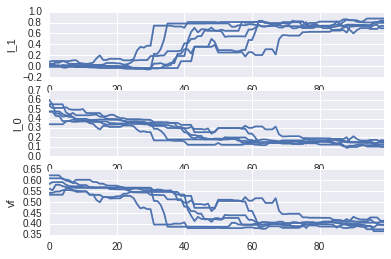

In [15]:
fig, (ax_l1, ax_l0, ax_vf) = plt.subplots(3)
ax_vf.set(ylabel='vf')
ax_l0.set(ylabel='l_0')
ax_l1.set(ylabel='l_1')
for i in range(6):
    sns.tsplot(vf[i,:], ax=ax_vf)
    sns.tsplot(l0[i,:], ax=ax_l0)
    sns.tsplot(l1[i,:], ax=ax_l1)

##### Estimate the most likely volume fraction

The most likely volume fraction is found by calculating the median value of the volume fraction traces after cutting off the burn-in time. We calculate a 68% confidence interval using the built-in numpy percentile function.

In [23]:
# trim off the burn in time, which we observe from the plots above
trim_index = 50
vf = np.ndarray.flatten(vf[:,trim_index:])

# find the median of the volume fractions of the walkers
vf_inferred = np.median(vf)
print("The inferred volume fraction is {:.3f} + {:.3f} - {:.3f}".format(vf_inferred,
                                                                       np.percentile(vf,84)-vf_inferred,
                                                                       vf_inferred - np.percentile(vf,16)))

The inferred volume fraction is 0.404 + 0.026 - 0.016
